# 📘 Урок: Работа в DWH через Python

## SQLAlchemy

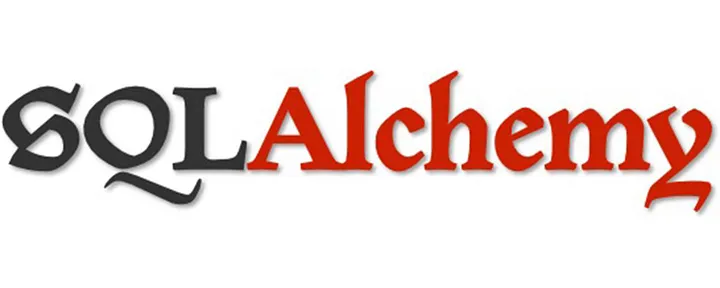

В реальных компаниях, как правило, Data Scientist коннектится к DWH с помощью **SQLAlchemy** — единый коннектор к любой SQL-базе:

* PostgreSQL
* MySQL
* Snowflake
* Redshift
* BigQuery (через драйвер)
* SQLite (в нашем случае используем его)

и др.

SQLAlchemy решает задачу **унифицированного доступа**:

- один API -> множество разных DWH

- удобно использовать в Jupyter

- позволяет писать SQL прямо в ноутбуке

- управляет подключениями

- поддерживает и ORM, и обычные SQL-запросы




##  Почему в качестве БД использована SQLite?

Потому что:

* SQLite легко создать локально
* не требует сервера
* хорошо подходит для учебных задач
* красиво демонстрирует все SQL-приёмы

Но важно понимать:

> В реальной работе вместо SQLite будет **настоящее DWH**, а SQLAlchemy остаётся тем же.

Подключение к базе

In [ ]:
import os
import requests
import pandas as pd
from sqlalchemy import create_engine

# URL к базе
url = "https://raw.githubusercontent.com/totiela/stepik_simulator_ds/main/lessons/lesson_3_2/dwh_base.db"
local_path = "dwh_base.db"

# Скачиваем файл, если его нет
if not os.path.exists(local_path):
    r = requests.get(url)
    r.raise_for_status()
    with open(local_path, "wb") as f:
        f.write(r.content)

# Подключение через SQLAlchemy
engine = create_engine(f"sqlite:///{local_path}")

In [ ]:
# Проверяем: выводим список таблиц
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", engine)

## Описание данных

### 🟦 1. Source Layer (SRC RAW) — *сырые данные как из CRM/логов*

Это **оригинальные данные**, которые обычно приходят:

* из CRM,
* из API,
* из логов мобильного/веб-приложения,
* из кассовых систем,
* из CSV/Excel файлов.

В них могут быть ошибки, пропуски, странные форматы.

### Таблицы:

| Таблица                     | Что хранит                     | Почему сырое?                                                        |
| --------------------------- | ------------------------------ | -------------------------------------------------------------------- |
| **`src__customers_raw`**    | Имена, телефоны, даты рождения | Разные форматы дат, VIP-флаг как `yes/no/Y/N`, возможны пропуски     |
| **`src__accounts_raw`**     | Счета клиентов                 | Балансы могут быть отрицательные, статусы — нестандартные            |
| **`src__transactions_raw`** | Транзакции                     | Суммы могут быть отрицательные/ошибочные, нет нормального ID клиента |
| **`src__events_raw`**       | Логи действий                  | Много шума, повторов, нет нормальной типизации                       |

In [ ]:
pd.read_sql("SELECT * FROM src__customers_raw LIMIT 3;", engine)

### 🟧 2. Staging Layer (STG) — *приведённые в порядок данные*

STG — это слой, где сырые данные проходят первичную очистку и нормализацию, чтобы их можно было безопасно использовать дальше.

Это НЕ аналитическая модель, но это уже данные, с которыми:

* не «ломается» преобразование типов,
* корректно работают JOIN’ы,
* можно считать агрегаты,
* можно строить витрины.

По сути, STG — это **буфер между хаосом RAW и структурой DWH**.

### Таблицы:

| Таблица                 | Что изменили                                                                 |
| ----------------------- | ---------------------------------------------------------------------------- |
| **`stg__customers`**    | Стандартизировали имена колонок, преобразовали `vip_flag`, даты — в datetime |
| **`stg__accounts`**     | Привели типы, стандартизировали тип счета                                    |
| **`stg__transactions`** | Чистый timestamp, правильные названия колонок                                |
| **`stg__events`**       | Привели формат времени и типы событий                                        |

In [ ]:
pd.read_sql("SELECT * FROM stg__customers LIMIT 3;", engine)

### 🟩 3. DWH Layer (ядро хранилища)

Это **сердце хранилища**, где данные превращаются в:


Справочники и «понятия»

| Таблица                 | Описание                                                               |
| ----------------------- | ---------------------------------------------------------------------- |
| **`dwh__dim_customer`** | Измерение клиента: ФИО, телефон, дата рождения, единообразный VIP-флаг |
| **`dwh__dim_account`**  | Измерение счёта: тип, дата открытия, клиент                            |


События, которые можно считать, суммировать.

| Таблица                      | Описание                             |
| ---------------------------- | ------------------------------------ |
| **`dwh__fact_transactions`** | Все транзакции, привязанные к счетам |
| **`dwh__fact_events`**       | Все действия клиентов в приложении   |

In [ ]:
pd.read_sql("SELECT * FROM dwh__fact_transactions LIMIT 5;", engine)

In [ ]:
pd.read_sql("SELECT customer_id, COUNT(*) FROM dwh__fact_events GROUP BY 1 LIMIT 5;", engine)

### 🟨 4. Consumption Layer (MARTS)* — витрины которые уже создал Data Scientist

Это слой, на котором появляются **готовые фичи**:

* агрегаты,
* суммы,
* окна,
* поведенческие признаки.

| Таблица                     | Описание                                                           |
| --------------------------- | ------------------------------------------------------------------ |
| **`mrt__account_features`** | Суммы, средние, мин/макс транзакций по каждому счёту — готово к ML |


In [ ]:
pd.read_sql("SELECT * FROM mrt__account_features LIMIT 3;", engine)

### Работа с DWH

In [ ]:
# Сколько событий на каждого клиента?
pd.read_sql("""
SELECT customer_id, COUNT(*) AS events
FROM dwh__fact_events
GROUP BY 1
ORDER BY events DESC
LIMIT 5;
""", engine)


In [ ]:
# Выявление счетов с ночной активностью - может быть полезно для модели антифрода
pd.read_sql("""
SELECT
    t.account_id,
    COUNT(*) AS night_txn
FROM dwh__fact_transactions t
WHERE CAST(STRFTIME('%H', t.txn_time) AS INTEGER) BETWEEN 0 AND 5
GROUP BY t.account_id;

""", engine)

In [ ]:
# Средний баланс по типам счетов
pd.read_sql("""
SELECT acc_type, AVG(balance) AS avg_balance
FROM dwh__dim_account
GROUP BY acc_type;
""", engine)


In [ ]:
# готовый набор признаков: баланс, транзакции, активность, поведение
df_features = pd.read_sql("""
SELECT
    a.customer_id,
    SUM(f.amount_sum) AS total_spent,
    SUM(f.txn_count) AS total_txn,
    AVG(a.balance) AS avg_balance,
    c.vip_flag,
    c.signup_channel,
    COUNT(e.event_id) AS event_count
FROM dwh__dim_customer c
LEFT JOIN dwh__dim_account a ON c.customer_id = a.customer_id
LEFT JOIN mrt__account_features f ON a.account_id = f.account_id
LEFT JOIN dwh__fact_events e ON c.customer_id = e.customer_id
GROUP BY c.customer_id;
""", engine)

df_features.head()


** в зависимости от того что мы хотим предсказывать, здесь может быть утечка данных, об этом поговорим позже!

### Самостоятельное задание

1. Посчитать клиентов, у которых больше 3х активных счетов

P.S. Активным является любой счет в `dwh__dim_account`

In [ ]:
pd.read_sql("""
    # ваш запрос
""", engine)

Вопрос 1: Сколько клиентов имеют более 3 активных счетов?

 -> ответ внести в Stepik

2. Посчитать количество транзакций по типам (`debit` / `credit`)**
Транзакции лежат в `dwh__fact_transactions`, а тип счёта — в `dwh__dim_account`.

In [ ]:
pd.read_sql("""
# ваш запрос
""", engine)

Вопрос 2: какое количество транзакций у счетов типа `debit`?

 -> ответ внести в Stepik

3. Посичтать сколько клиентов (*customer_id*) совершили больше 15 событий (`dwh__fact_events`) и более 5 транзакций (`dwh__fact_transactions`)?

In [ ]:
pd.read_sql("""
    # ваш запрос
""", engine)

Вопрос 3: Сколько клиентов совершили больше 15 событий (dwh__fact_events) и более 5 транзакций (dwh__fact_transactions)?

 -> ответ внести в Stepik